# Description

Calculates the Bayesian credibility for the hypothesis that the real single trial success rate during a test B is higher than that during a test A, given the number of conducted trials and number of successful tests for both test run A and B.

# Parameters

In [1]:
n_trials_A = 100
n_successes_A = 80

n_trials_B = 10
n_successes_B = 9

round_to_digits = 4

assert isinstance(n_trials_A, int) and n_trials_A >= 0
assert isinstance(n_trials_B, int) and n_trials_B >= 0
assert isinstance(n_successes_A, int) and 0 <= n_successes_A <= n_trials_A
assert isinstance(n_successes_B, int) and 0 <= n_successes_B <= n_trials_B
assert isinstance(round_to_digits, int) and round_to_digits >= 1

# Evaluation

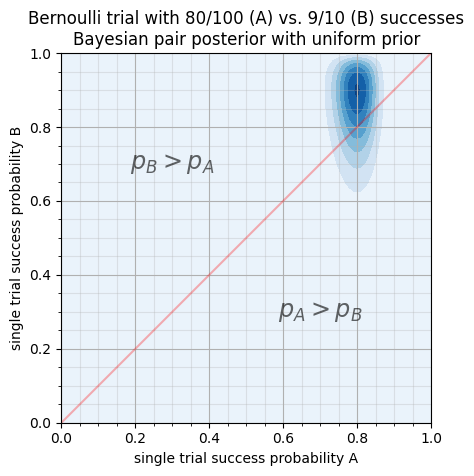

In [2]:
import matplotlib.pyplot as plt
import mpmath as mp
import numpy as np
from scipy import integrate

mp.mp.dps = 50 #use 50 decimal digits precision in mpmath calculations

def posterior_prob_binom_p(p, n_trials, n_successes, prior):
    return mp.power(mp.mpf(p), n_successes) * mp.power(mp.mpf(1-p), (n_trials-n_successes)) * prior(p)

posterior_prob_binom_p_vectorized = np.vectorize(posterior_prob_binom_p)

def posterior_pairs(p_A, n_trials_A, n_successes_A, prior_A, p_B, n_trials_B, n_successes_B, prior_B):
    return posterior_prob_binom_p_vectorized(X, n_trials_A, n_successes_A, prior=prior_A) * posterior_prob_binom_p_vectorized(Y, n_trials_B, n_successes_B, prior=prior_B)

#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large n_trial
def integrate_posterior_prob_binom_p_norm(n_trials, n_successes, prior, bounds):
    mean = n_successes / n_trials
    std_dev = ( (n_successes-1)*(n_trials-n_successes+1) / (n_trials**2*(n_trials+1)) )**0.5
    prescale = 1/posterior_prob_binom_p(mean,n_trials, n_successes, prior)
    prior_prescaled = lambda p: prior(p) * prescale
    
    norm = 0
    if bounds[0] < mean-3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(0, bounds[0]), min(mean-3*std_dev, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < mean and bounds[1] >= mean-3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(mean-3*std_dev, bounds[0]), min(mean, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < mean+3*std_dev and bounds[1] >= mean:
        norm += integrate.quad(posterior_prob_binom_p, max(mean, bounds[0]), min(mean+3*std_dev, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
    if bounds[0] < 1 and bounds[1] >= mean+3*std_dev:
        norm += integrate.quad(posterior_prob_binom_p, max(mean+3*std_dev, bounds[0]), min(1, bounds[1]), args=(n_trials, n_successes, prior_prescaled))[0]
        
    return norm / prescale
    
p_A = np.linspace(0, 1, 101)
p_B = np.linspace(0, 1, 101)

prior_A = lambda p: 1
prior_B = lambda p: 1

norm_A = integrate_posterior_prob_binom_p_norm(n_trials_A, n_successes_A, prior_A, [0, 1])
norm_B = integrate_posterior_prob_binom_p_norm(n_trials_B, n_successes_B, prior_B, [0, 1])

X, Y = np.meshgrid(p_A, p_B)
posterior_probs = posterior_pairs(X, n_trials_A, n_successes_A, prior_A, Y, n_trials_B, n_successes_B, prior_B) / (norm_A * norm_B)

plt.contourf(X, Y, posterior_probs, cmap='Blues')
plt.axline([0,0], [1,1], color='red', alpha=0.3)
plt.text(0.3, 0.7, '$p_B > p_A$', horizontalalignment='center', verticalalignment='center', fontsize='xx-large', fontweight='bold', alpha=0.6)
plt.text(0.7, 0.3, '$p_A > p_B$', horizontalalignment='center', verticalalignment='center', fontsize='xx-large', fontweight='bold', alpha=0.6)

plt.gca().set_title('Bernoulli trial with {}/{} (A) vs. {}/{} (B) successes\nBayesian pair posterior with uniform prior'.format(n_successes_A, n_trials_A, n_successes_B, n_trials_B))
plt.gca().set_xlabel('single trial success probability A')
plt.gca().set_ylabel('single trial success probability B')
plt.gca().tick_params(axis='x', which='minor', bottom=True)
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3);
plt.gca().set_aspect('equal')